In [78]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import pandas as pd
from copy import deepcopy

In [79]:
fashion_train = datasets.FashionMNIST(
    root='../data/FasionMNIST_data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
fashion_test = datasets.FashionMNIST(
    root='../data/FasionMNIST_data/',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

In [80]:
x = (fashion_train.data.float() / 255)
x = x.view(x.size(0), -1)
y = fashion_train.targets

input_size = x.size(-1)
output_size = len(np.unique(y))
print(input_size, output_size)

train_cnt = int(x.size(0) * 0.8)   # 60000 * 0.8
valid_cnt = int(x.size(0) * 0.2)   # 60000 * 0.2
test_cnt = len(fashion_test)
cnts = [train_cnt, valid_cnt]
train_dataset, valid_dataset = random_split(fashion_train, cnts)

784 10


In [81]:
batch_size = 256
train_loader = DataLoader(
    dataset=train_dataset.dataset,
    batch_size=batch_size,
    shuffle=True)

valid_loader = DataLoader(
    dataset=valid_dataset.dataset,
    batch_size=batch_size,
    shuffle=True)

test_loader = DataLoader(
    dataset=fashion_test,
    batch_size=batch_size,
    shuffle=True)

In [82]:
model = nn.Sequential(
    nn.Linear(input_size, 400),
    nn.LeakyReLU(),
    nn.BatchNorm1d(400),
    nn.Linear(400, 200),
    nn.LeakyReLU(),
    nn.BatchNorm1d(200),
    nn.Linear(200, 100),
    nn.LeakyReLU(),
    nn.BatchNorm1d(100),
    nn.Linear(100, 50),
    nn.LeakyReLU(),
    nn.BatchNorm1d(50),
    nn.Linear(50, 25),
    nn.LeakyReLU(),
    nn.BatchNorm1d(25),
    nn.Linear(25, output_size),
    nn.LogSoftmax(dim=-1)
)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())
epochs = 100

lowest_loss = np.inf
best_model = None
early_stop = 10
lowest_epoch = np.inf

train_history, valid_history = [], []

In [83]:
for epoch in range(epochs + 1):
    total_batch_train = len(train_loader)
    train_loss = 0

    for x, y in train_loader:
        x = (x.float() / 255).view(x.size(0), -1)

        y_hat = model(x)
        loss = criterion(y_hat, y.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += float(loss)
    train_loss = train_loss / total_batch_train

    with torch.no_grad():
        total_batch_valid = len(valid_loader)
        valid_loss = 0
        for x, y in valid_loader:
            x = (x.float() / 255).view(x.size(0), -1)

            y_hat = model(x)
            loss = criterion(y_hat, y.squeeze())

            valid_loss += float(loss)
        valid_loss = valid_loss / total_batch_valid

    train_history += [train_loss]
    valid_history += [valid_loss]

    if epoch % 5 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Lowest Valid Loss: {lowest_loss:.4f}')

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = epoch
        best_model = deepcopy(model.state_dict())
    else:
        if (early_stop > 0) and (lowest_epoch + early_stop < epoch):
            print(f'{lowest_epoch} 이후 {early_stop} epoch 증가하는 동안 손실함수 감소 없음')
            break

print(f'epoch {lowest_epoch}일 때 최소 손실함수: {lowest_loss}')

Epoch: 0 | Train Loss: 0.6116 | Valid Loss: 0.3947 | Lowest Valid Loss: inf
Epoch: 5 | Train Loss: 0.2657 | Valid Loss: 0.2422 | Lowest Valid Loss: 0.2480
Epoch: 10 | Train Loss: 0.2111 | Valid Loss: 0.1971 | Lowest Valid Loss: 0.2042
Epoch: 15 | Train Loss: 0.1730 | Valid Loss: 0.1482 | Lowest Valid Loss: 0.1690
Epoch: 20 | Train Loss: 0.1400 | Valid Loss: 0.1330 | Lowest Valid Loss: 0.1324
Epoch: 25 | Train Loss: 0.1209 | Valid Loss: 0.1057 | Lowest Valid Loss: 0.1061
Epoch: 30 | Train Loss: 0.0977 | Valid Loss: 0.0945 | Lowest Valid Loss: 0.0938
Epoch: 35 | Train Loss: 0.0877 | Valid Loss: 0.0784 | Lowest Valid Loss: 0.0743
Epoch: 40 | Train Loss: 0.0728 | Valid Loss: 0.0680 | Lowest Valid Loss: 0.0598
Epoch: 45 | Train Loss: 0.0702 | Valid Loss: 0.0580 | Lowest Valid Loss: 0.0521
Epoch: 50 | Train Loss: 0.0565 | Valid Loss: 0.0471 | Lowest Valid Loss: 0.0472
Epoch: 55 | Train Loss: 0.0560 | Valid Loss: 0.0415 | Lowest Valid Loss: 0.0462
Epoch: 60 | Train Loss: 0.0473 | Valid Loss: 

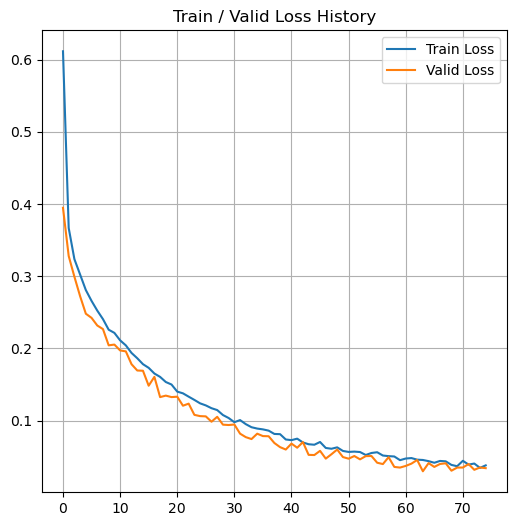

In [84]:
plot_from = 0

plt.figure(figsize=(6, 6))
plt.grid(True)
plt.title('Train / Valid Loss History')
plt.plot(range(plot_from, len(train_history)), train_history[plot_from:], label='Train Loss')
plt.plot(range(plot_from, len(valid_history)), valid_history[plot_from:], label='Valid Loss')
plt.legend()
plt.show()

In [85]:
test_loss = 0
y_hat_list = []

with torch.no_grad():
    for x, y in test_loader:
        x = (x.float() / 255).view(x.size(0), -1)

        y_hat = model(x)
        loss = criterion(y_hat, y)

        test_loss += float(loss)
        y_hat_list += [y_hat]
test_loss = test_loss / len(valid_loader)

y_hat_list = torch.cat(y_hat_list, dim=0)

print('Test Loss:', test_loss)

Test Loss: 0.10507726066924156


In [86]:
correct_cnt = (fashion_test.targets == torch.argmax(y_hat_list, dim=-1)).sum()
print(correct_cnt / 10000)

tensor(0.1036)


In [87]:
from sklearn.metrics import confusion_matrix

df = pd.DataFrame(confusion_matrix(fashion_test.targets, torch.argmax(y_hat_list, dim=-1)))
df

,0,1,2,3,4,5,6,7,8,9
0,119,111,93,101,94,89,98,103,96,96
1,119,99,108,119,85,91,97,95,89,98
2,104,96,105,99,81,118,100,110,90,97
3,95,87,106,80,90,104,92,126,119,101
4,94,99,114,107,105,106,92,101,87,95
5,100,89,103,109,101,114,91,89,107,97
6,99,85,108,97,102,86,99,115,104,105
7,102,108,108,94,106,92,99,94,101,96
8,89,118,117,98,89,109,93,89,104,94
9,110,99,96,98,107,83,95,96,99,117
